In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from EEGModels import EEGNet # EEGNet from https://github.com/vlawhern/arl-eegmodels

In [2]:
WINDOW_SIZE = 150 # size of WINDOW_SIZE was chosen based on the data's sampling rate. This is not the final value, just a baseline to use for experimentation.

## Prepare Dataset

### Import Dataset

In [3]:
# raw_df = pd.read_csv('A160223-raw-data.csv')
raw_df = pd.read_csv('B1602256-raw-data.csv')
raw_df.shape

(667000, 23)

In [4]:
# check for null/missing values
print(raw_df.isna().sum().sum()) # returns a sum of missing values in the entire dataframe.
# a returned value of 0 means there are no missing values.

0


### Explore The Dataset's Labels and Content

<a href=https://chatgpt.com/share/67d9c114-f5cc-8000-ae83-645f4f3763af>ChatGPT conversation for generating matplotlib/pandas code</a>

Index(['Marker', 'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
       'A1', 'A2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'X3'],
      dtype='object')
Distribution samples for each class:
Marker
0     422843
1      28310
2      33008
3      32577
4      36652
5      31550
6      33015
91     48013
92       207
99       825
dtype: int64


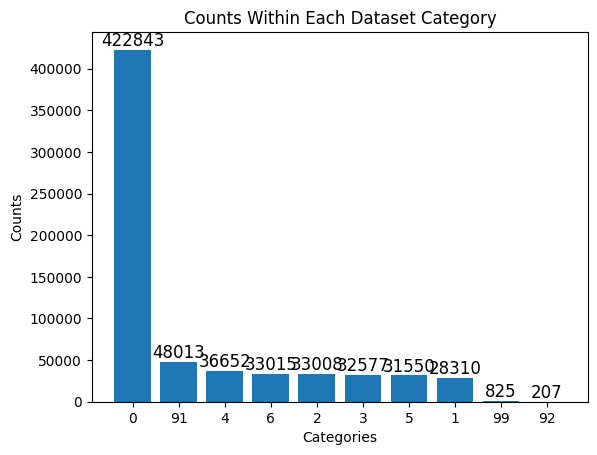

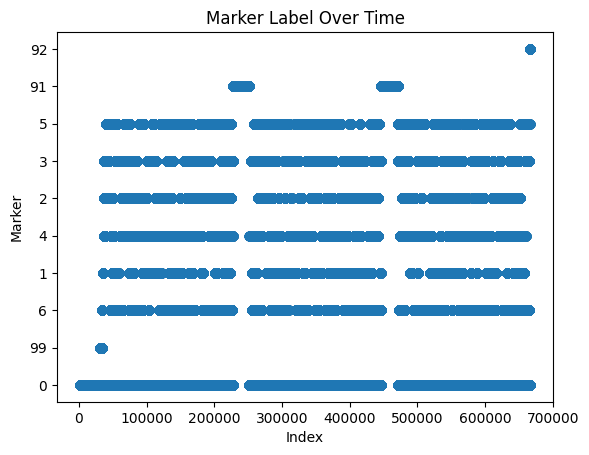

In [5]:
print(raw_df.columns)
print(f'Distribution samples for each class:\n{raw_df.groupby('Marker').size()}')
marker_counts = raw_df['Marker'].value_counts()
categories = marker_counts.index.astype('string') # as string so that it treats the categories as nominal data

# plot distribution of categories
# print(categories)
plt.bar(categories, marker_counts)
plt.title('Counts Within Each Dataset Category')
plt.xlabel('Categories')
plt.ylabel('Counts')
for i, count in enumerate(marker_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)
plt.show()

# plot category labels over time

# https://stackoverflow.com/questions/69449107/plotting-a-pyplot-graph-with-a-single-column-of-data
# plt.plot(raw_df.loc[:, 'Marker'].astype('string'))
MIN_VALUE = 0 
MAX_VALUE = len(raw_df)
lower_bound = 1000 # MIN_VALUE
upper_bound = MAX_VALUE # MAX_VALUE
plt.scatter(range(lower_bound, upper_bound), raw_df['Marker'][lower_bound:upper_bound].astype(str))
plt.title('Marker Label Over Time')
plt.xlabel('Index')
plt.ylabel('Marker')
plt.show()

Based on the above plots, the 0 label makes up the majority of the labels in the dataset.

#### Category labels:

- 0: Not specified in dataset documentation; Unknown
- 1: Left Hand
- 2: Right Hand
- 3: Passive State (no imagined movement)
- 4: Left Leg
- 5: Tongue
- 6: Right Leg
- 91: Inter-trial relaxation period
- 92: Experiment End
- 99: Initial relaxation period

### Analyze the mysterious "0" class

<a href=https://claude.ai/share/b7b382cb-6340-4e55-9f61-9de69a69e397>Decisions related to the "0" class</a>

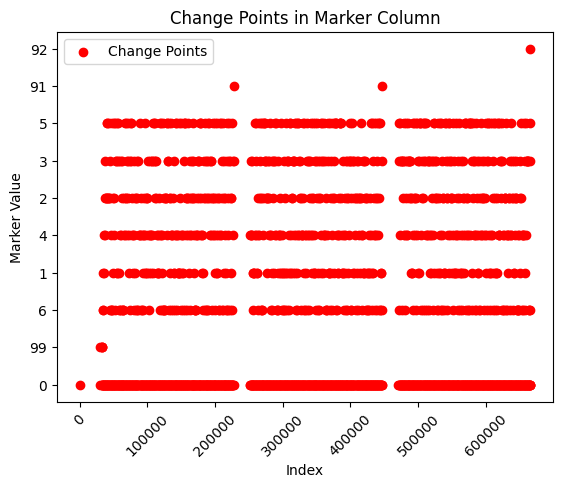

Transition Matrix
NextMarker      0      1      2      3      4      5      6      91   92   99
PrevMarker                                                                   
0.0         421877    139    162    160    180    155    162      2    1    4
1.0            139  28171      0      0      0      0      0      0    0    0
2.0            162      0  32846      0      0      0      0      0    0    0
3.0            160      0      0  32417      0      0      0      0    0    0
4.0            180      0      0      0  36472      0      0      0    0    0
5.0            155      0      0      0      0  31395      0      0    0    0
6.0            162      0      0      0      0      0  32853      0    0    0
91.0             2      0      0      0      0      0      0  48011    0    0
92.0             1      0      0      0      0      0      0      0  206    0
99.0             4      0      0      0      0      0      0      0    0  821


In [6]:
# Find where 'Marker' values change
change_points = raw_df['Marker'] != raw_df['Marker'].shift()

plt.scatter(raw_df.index[change_points], raw_df['Marker'][change_points].astype(str), color='red', label="Change Points")

plt.xlabel("Index")
plt.ylabel("Marker Value")
plt.title("Change Points in Marker Column")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Create a DataFrame of transitions
transitions = pd.DataFrame({'PrevMarker': raw_df['Marker'].shift(), 'NextMarker': raw_df['Marker']})

# Drop rows where PrevMarker is NaN (first row)
transitions = transitions.dropna()

# Count occurrences of each transition and create a transition matrix
transition_matrix = transitions.groupby(['PrevMarker', 'NextMarker']).size().unstack(fill_value=0)

print("Transition Matrix")
print(transition_matrix)

# one idea of what "0" could be: what if it's points where the device tried to collect a sample but it was bad data or duplicate data? When another sample wasn't ready.

Based on the above plot/matrix, all of the other markers have a set of "0" markers in between them. They appear to be the transition between each class.

C:\Users\smcke\AppData\Local\Temp\ipykernel_24304\1572994995.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True, patch_artist=True)  # 'vert=True' keeps boxes vertical


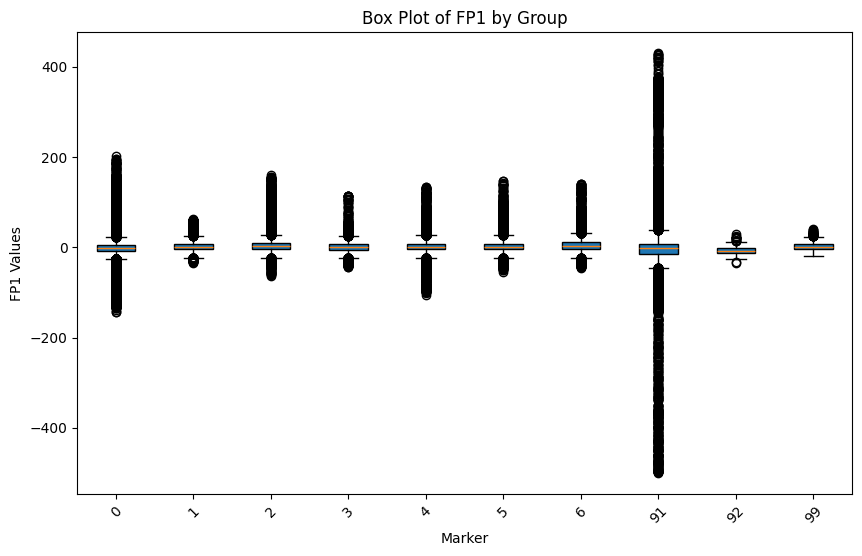

mean: Marker
0    -1.326401
1     1.859696
2     4.409962
3     1.427084
4     1.779527
5     2.876738
6     5.195079
91   -0.069849
92   -6.969469
99    2.747297
Name: FP1, dtype: float64
median: Marker
0    -1.14
1     1.34
2     2.05
3     1.17
4     1.44
5     1.75
6     3.83
91   -2.64
92   -8.43
99    1.10
Name: FP1, dtype: float64


In [7]:
# plot the values by group in a box plot to show distributions of values.

# Group by 'Marker' and collect values
grouped = raw_df.groupby('Marker')['FP1']

# Prepare data for boxplot
data = [group.values for _, group in grouped]
labels = [name for name, _ in grouped]

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, vert=True, patch_artist=True)  # 'vert=True' keeps boxes vertical

plt.xlabel("Marker")
plt.ylabel("FP1 Values")
plt.title("Box Plot of FP1 by Group")
plt.xticks(rotation=45)  # Rotate labels if needed
plt.show()
print(f'mean: {grouped.mean()}\nmedian: {grouped.median()}')

Based on the above plots/measures, the "0" label appears to be similar to the rest period labels (the label "91")

        Marker  Length
30652       99   30652
30857        0     205
32467       99    1610
32674        0     207
33076       99     402
...        ...     ...
665095       0     203
665402       5     307
665605       0     203
665606      92       1
665813       0     207

[1930 rows x 2 columns]


<BarContainer object of 10 artists>

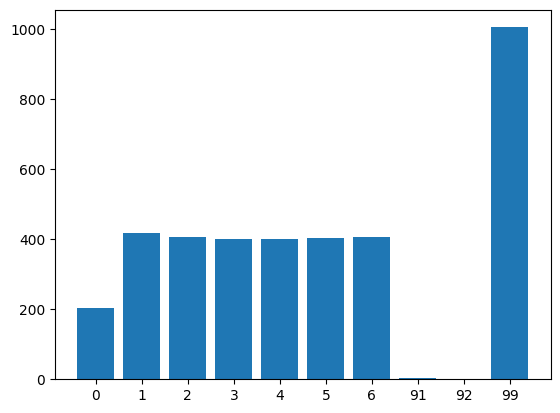

In [8]:
# Get segment start indices
segment_starts = raw_df.index[change_points]

# Compute segment lengths
segment_lengths = segment_starts.to_series().diff().dropna().astype(int)

# Associate each segment length with its corresponding Marker
segment_labels = raw_df.loc[segment_starts[1:], 'Marker'].values  # Skip first since diff() removes one

# Create a DataFrame for analysis
segment_length_data = pd.DataFrame({'Marker': segment_labels, 'Length': segment_lengths})

print(segment_length_data)
segment_length_groups = segment_length_data.groupby('Marker')
group_names_string = [str(name) for name in segment_length_groups.groups.keys()]
plt.bar(group_names_string, segment_length_groups.median()['Length'])

Based on the above code, the length of data segments with the label "0" are typically shorter than other label segments

#### Conclusions about Label "0" (Unknown)

For the following reasons, I have decided the "0" label can be filtered out of the dataset:
- I already have class "3" as your intended neutral/baseline state
- I have observed that "0" appears between all other class transitions
- I have sufficient data (~200,000 points) remaining after removing the 0 label datapoints
- I have observed through box plots that "0" resembles rest periods
- I have observed that data segments with the label "0" tends to be shorter than the data segments of other labels

All of the above points suggest that the data labeld with "0" may be buffer/transition datapoints that do not have actual class data associated with them.

If I consider that this data (with labels of 0) could contain information about the transition between classes, I may find a way to introduce these datapoints back into the dataset if necessary. 

### Filter Dataset

In [9]:
# filter the dataframe so that it only contains the relevant classes (1-6) for each motor imagery task
filtered_df = raw_df[(raw_df['Marker'] > 0) & (raw_df['Marker'] < 90)]
print(filtered_df['Marker'].value_counts())

Marker
4    36652
6    33015
2    33008
3    32577
5    31550
1    28310
Name: count, dtype: int64


### Display Dataset Metrics

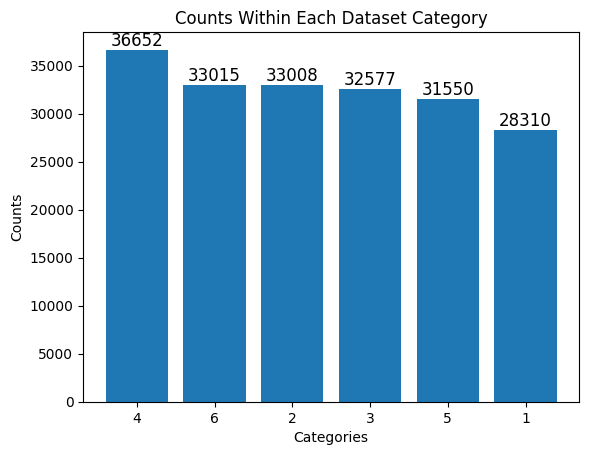

In [10]:
# distribution of remaining classes:
filtered_marker_counts = filtered_df['Marker'].value_counts()
filtered_categories = filtered_marker_counts.index.astype('string') # as string so that it treats the categories as nominal data

# plot distribution of categories
plt.bar(filtered_categories, filtered_marker_counts)
plt.title('Counts Within Each Dataset Category')
plt.xlabel('Categories')
plt.ylabel('Counts')
for i, count in enumerate(filtered_marker_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)
plt.show()

### Sliding Window

In [26]:
window_data = np.lib.stride_tricks.sliding_window_view(x=filtered_df, window_shape=WINDOW_SIZE, axis=0)

window_formatted = window_data.reshape(window_data.shape[0], window_data.shape[1], window_data.shape[2]) 

print(window_formatted.shape)

(194963, 23, 150)


In [27]:
# separate data into samples and labels (X and y)
X = window_formatted[:, 1:22, :]
y = window_formatted[:, 0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(136474, 21, 150)
(58489, 21, 150)
(136474, 150)
(58489, 150)


In [37]:
# convert labels from (window_count, sample_labels, 1) => (window_label,)
# bincount doesn't accept floats, which is the original format the labels are stored in
y_train_asInt = y_train.astype(np.int64) - 1 # -1 to change from labels of 1-6 to 0-5
y_val_asInt = y_val.astype(np.int64) - 1
most_frequent_train_labels = np.apply_along_axis(lambda x: np.bincount(x.flatten()).argmax(), axis=1, arr=y_train_asInt)
most_frequent_val_labels = np.apply_along_axis(lambda x: np.bincount(x.flatten()).argmax(), axis=1, arr=y_val_asInt)
print(most_frequent_train_labels.shape)
y_train_one_hot = np.eye(6)[most_frequent_train_labels.astype(int)]  # One-hot encode for 6 classes
y_val_one_hot = np.eye(6)[most_frequent_val_labels.astype(int)] # One-hot encode for 6 classes
print(y_train_one_hot.shape)

(136474,)
(136474, 6)


In [30]:
# add a dimension to the end to match the expected shape for EEGNet
# y_train_one_hot = y_train_one_hot[..., np.newaxis]
# y_val_one_hot = y_val_one_hot[..., np.newaxis]
# y_train_one_hot.shape

(136474, 6, 1)

### New Catagory Labels:

- 0: Left Hand
- 1: Right Hand
- 2: Passive State (no imagined movement)
- 3: Left Leg
- 4: Tongue
- 5: Right Leg

## Machine Learning

In [38]:
''' 
    EEGNet "Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well."
''' # TODO: adjust for this. My training/validation data is sampled at 1000Hz. The testing/runtime data will be at 100Hz if I use the Brain Products Actichamp system
# EEGNet from: https://github.com/vlawhern/arl-eegmodels
model = EEGNet(nb_classes=6, Chans=X_train.shape[1], Samples=X_train.shape[2])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 21, 150, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 150, 8)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 21, 150, 8)          │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 1, 150, 16)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1, 150, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1, 150, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 1, 37, 16)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 37, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 1, 37, 16)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1, 37, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1, 37, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 1, 4, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 6)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,910 (7.46 KB)

 Trainable params: 1,830 (7.15 KB)

 Non-trainable params: 80 (320.00 B)

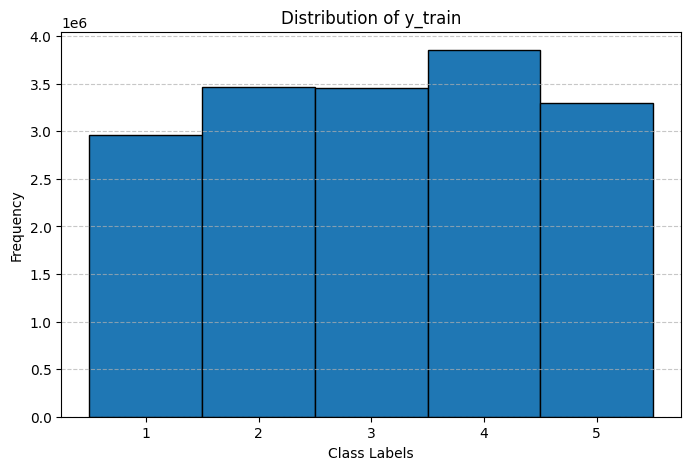

In [39]:
# Ensure y_train is a 1D array
y_train_flat = np.ravel(y_train)

plt.figure(figsize=(8, 5))
plt.hist(y_train_flat, bins=np.arange(y_train_flat.min(), y_train_flat.max() + 1) - 0.5, edgecolor='black')
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Distribution of y_train")
# plt.xticks(range(y_train_flat.min(), y_train_flat.max() + 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [43]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy']) # one-hot encoding
print(X_train.shape)
print(y_train_one_hot.shape)
fittedModel    = model.fit(x=X_train,y=y_train_one_hot,epochs=1)

(136474, 21, 150)
(136474, 6)
4265/4265 ━━━━━━━━━━━━━━━━━━━━ 744s 24ms/step - accuracy: 0.3841 - loss: 1.5385


## Evaluate Predictions

In [ ]:
predictions      = model.predict(X_val)
print(predictions.shape)
print(predictions)

1530/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [ ]:
# Convert one-hot to label encoding
y_val_labels = np.argmax(y_val_one_hot, axis=1).reshape(-1)
y_pred_labels = np.argmax(predictions, axis=1)
print(y_val_one_hot.shape)
print(predictions.shape)
print(y_val_labels.shape)
print(y_pred_labels.shape)

# Compute confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")